# Latent Dirichlet Allocation (LDA) for MR Route Descriptions

In [1]:
import numpy as np
import pandas as pd
import gensim
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

In [2]:
#import data
valid_states = ['Alabama', 'California', 'Georgia', 'Missouri', 'Illinois', 'Ohio',
       'Kentucky', 'Colorado', 'United States', 'Indiana', 'New York',
       'Vermont', 'Texas', 'Florida', 'Minnesota', 'Virginia',
       'Oklahoma', 'Arkansas', 'Maryland', 'West Virginia',
       'Michigan', 'North Carolina', 'Oregon', 'Pennsylvania',
       'Washington', 'New Jersey', 'Alaska',
       'South Carolina', 'Utah', 'New Hampshire', 'Iowa', 'Louisiana',
       'Mississippi', 'Wisconsin',
       'South Dakota', 'Wyoming', 'Massachusetts', 'New Mexico',
       'Montana', 'Idaho', 'Nevada', 'Arizona',
       'Kansas', 'Northeast', 'Southwest', 'Golf Coast', 'Southeast',
       'Tennessee', 'Nebraska', 'Delaware', 'Pacific Coast',
       'Appalachian Mountains', 'Maine', 'Rhode Island', 'Connecticut',
       'North Dakota', 'Hawaii']

route_data_RAW = pd.read_csv('route_data_RAW.csv')
route_data_RAW['description'] = route_data_RAW.agg(lambda x: f"{x['scenery_description']}, {x['drive_enjoyment_description']}, {x['tourism_description']}", axis=1)
route_data_RAW.description

0       The valley road winds beside the Paint Rock Ri...
1       The valley road winds beside the Paint Rock Ri...
2       Drive through a nice slide of Central Alabama ...
3       County Rd 14 west of the Natchez Trace runs al...
4       On this route you will find several homes and ...
                              ...                        
2069    The route travels through the SW Missouri plai...
2070    Goes through vineyards and rolling hills with ...
2071    The route goes through typical mid-Missouri co...
2072    This route has some of the best of the Missour...
2073    There are some beautiful lookout points along ...
Name: description, Length: 2074, dtype: object

In [4]:
#Preprocessing

STOP_WORDS = STOP_WORDS.union({'ll', 've', 'pron',
                                'good','great', 'nice',
                                'ride','route','road','rt','roads'
                              })

## Text Processing

In [45]:
ngram_range = (2,3)
vectorizer = CountVectorizer(ngram_range=ngram_range,
                             stop_words=STOP_WORDS,
                            )
analyzer = vectorizer.build_analyzer()

texts = route_data_RAW.scenery_description.values.tolist()
processed_text = [analyzer(text) for text in texts]

In [46]:
dictionary = gensim.corpora.Dictionary(processed_text)
print('Number of unique tokens: {}'.format(len(dictionary)))

Number of unique tokens: 116123


In [47]:
corpus = [dictionary.doc2bow(t) for t in processed_text]

## Initial LDA Model

In [59]:
#LDA model parameters
num_topics = 7
num_words = 10

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                            id2word=dictionary,
                                            num_topics=num_topics, 
                                            random_state=17, update_every=1,
                                            chunksize=1500, 
                                            passes=5, iterations=10,
                                            alpha='asymmetric', eta=1/100,
                                            per_word_topics=True)

pprint(lda_model.print_topics(num_words=num_words))

[(0,
  '0.012*"rolling hills" + 0.007*"small towns" + 0.005*"state park" + '
  '0.005*"national forest" + 0.004*"river valley" + 0.004*"little traffic" + '
  '0.004*"national park" + 0.003*"tree lined" + 0.003*"farm land" + '
  '0.002*"high desert"'),
 (1,
  '0.008*"rolling hills" + 0.007*"farm land" + 0.005*"river valley" + '
  '0.003*"state park" + 0.003*"mountain views" + 0.003*"places stop" + '
  '0.003*"winds way" + 0.003*"scenic byway" + 0.003*"national forest" + '
  '0.003*"tree lined"'),
 (2,
  '0.005*"rolling hills" + 0.004*"ohio river" + 0.003*"state park" + '
  '0.003*"continue north" + 0.003*"blue ridge" + 0.003*"puget sound" + '
  '0.003*"beautiful scenery" + 0.003*"heavily wooded" + 0.002*"forested areas" '
  '+ 0.002*"higher elevations"'),
 (3,
  '0.003*"speed limits" + 0.003*"places stop" + 0.002*"yuba river" + '
  '0.002*"table rock" + 0.002*"little towns" + 0.002*"11 miles" + 0.002*"rapid '
  'elevation changes" + 0.002*"lake tahoe" + 0.002*"bike 10" + 0.002*"look '
 

In [60]:
# get_document_topics method shows the topics found 
# in each corpus doc
lda_model.get_document_topics(corpus[1])

[(0, 0.010992302), (1, 0.9661714)]

In [61]:
# extracts dominant topic (and percentage) for each comment

def get_main_topic_df(model, bow, texts):
    topic_list = []
    percent_list = []
    keyword_list = []
    
    for wc in bow:
        topic, percent = sorted(model.get_document_topics(wc), key=lambda x: x[1], reverse=True)[0]
        topic_list.append(topic)
        percent_list.append(round(percent, 3))
        keyword_list.append(' '.join(sorted([x[0] for x in model.show_topic(topic)])))

    result_df = pd.concat([pd.Series(topic_list, name='Dominant_topic'), 
                           pd.Series(percent_list, name='Percent'), 
                           pd.Series(texts, name='Processed_text'), 
                           pd.Series(keyword_list, name='Keywords')], axis=1)

    return result_df

In [62]:
main_topic_df = get_main_topic_df(lda_model, corpus, processed_text)

In [63]:
# len(main_topic_df)

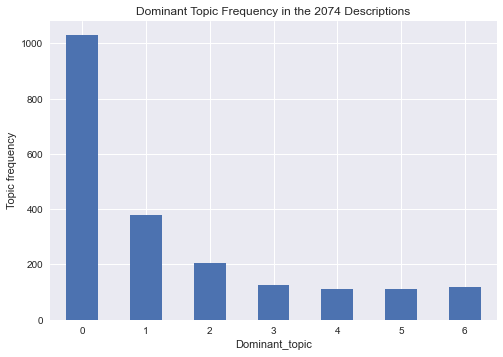

In [64]:
plt.style.use('seaborn')

grouped_topics = main_topic_df.groupby('Dominant_topic')
grouped_topics.count()['Processed_text'].\
    plot.bar(rot=0).\
    set(title=f'Dominant Topic Frequency in the {len(route_data_RAW)} Descriptions',
        ylabel='Topic frequency');


## Representative data

What's the "most representative" comment we have in the data for each topic?  

In [65]:
representatives = pd.DataFrame()

for k in grouped_topics.groups.keys():
    representatives = pd.concat([ representatives, 
                                 grouped_topics.get_group(k).sort_values(['Percent'], ascending=False).head(5)])
# representatives
for i in range(len(representatives)):
    print(f'''
        Document: {representatives.index[i]}  
        Dominant topic: {representatives.loc[representatives.index[i]]['Dominant_topic']}\n 
    ''')
    print(texts[representatives.index[i]] + '\n ------- \n')


        Document: 685  
        Dominant topic: 0
 
    
Climb out of the alpine meadows of Apline, AZ and travel through nearly all of the habitat zones available in New Mexico. As you descend through the pine forests you notice the gradual climb in temp and by the mid-point Buckhorn, you will need to start shedding some layers. Leaving Silver City, the road flattens out onto a high desert with tall grasses and few if any trees. Plenty places to pull over for photos and include the USFS Leopold picnic area. It is a nice area with an excellent description/map of the Gila Wilderness in the distance.
 ------- 


        Document: 736  
        Dominant topic: 0
 
    
Although much of the road is just going through the woods, there are some scenic overlooks and one fairly short stretch runs right along the lake.  You should take the side trip (12mi roundtrip) up to the Pictured Rocks overlook.  You'll get great views of Lake Superior which according to the National Park Service is "the 

There seem to be two dominant topics in this set of comments. 

Two types of roads:
1. Roads for the RIDE (Topic 0)
2. Roads for the VIEW (Topic 2)

## Length of documents in each topic

In [66]:
def word_count_by_topic(topic=0):
    d_lens = [len(d) for d in grouped_topics.get_group(topic)['Processed_text']]
    plt.hist(d_lens, bins=50)
    large = plt.gca().get_ylim()[1]
    d_mean = round(np.mean(d_lens), 1)
    d_median = np.median(d_lens)
    plt.plot([d_mean, d_mean], [0,large], label='Mean = {}'.format(d_mean))
    plt.plot([d_median, d_median], [0,large], label='Median = {}'.format(d_median))
    plt.legend()
    plt.gca().set(xlabel='Document word count', ylabel='Number of documents', xlim=(0, 450), 
            title='Distribution of Comment Lengths for {} Comments in Topic {}'.format(len(d_lens), topic));

In [67]:
slider = IntSlider(min=0, max=num_topics-1, step=1, value=0, description='Topic')
interact(word_count_by_topic, topic=slider);

interactive(children=(IntSlider(value=0, description='Topic', max=6), Output()), _dom_classes=('widget-interac…

## Top word distribution per topic

[Text(0, 0.5, 'Word frequency'),
 Text(0.5, 1.0, 'Word Frequencies by Topic, Combining the Top 52 Words in Each Topic')]

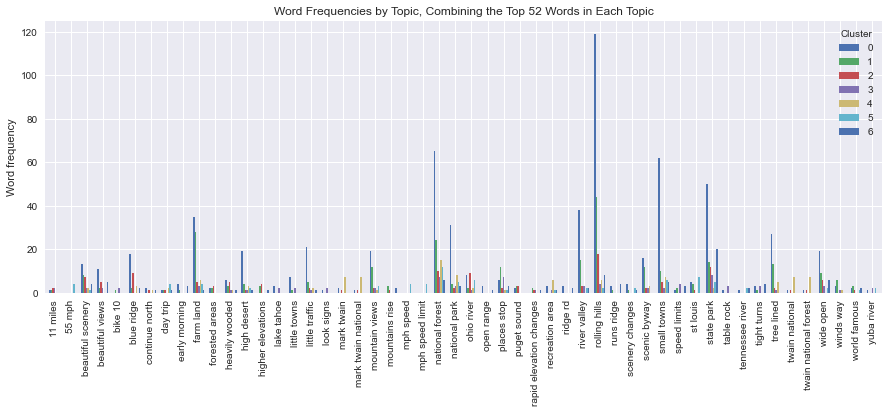

In [68]:
lda_top_words_index = set()
for i in range(lda_model.num_topics):
    lda_top_words_index = lda_top_words_index.union([k for (k,v) in lda_model.get_topic_terms(i)])


words_we_care_about = [{dictionary[tup[0]]: tup[1] for tup in lst if tup[0] in lda_top_words_index} 
                       for lst in corpus]

lda_top_words_df = pd.DataFrame(words_we_care_about).fillna(0).astype(int).sort_index(axis=1)
lda_top_words_df['Cluster'] = main_topic_df['Dominant_topic']

(
    lda_top_words_df
    .groupby('Cluster').sum().transpose()
    .plot.bar(figsize=(15, 5), width=0.7)
    .set(ylabel='Word frequency', 
         title=f'Word Frequencies by Topic, Combining the Top {len(lda_top_words_index)} Words in Each Topic')
)

## Coherence scores based on number of topics

Coherence scores for the ngram range: (2, 3) 
 [(1, 0.4911214295599162), (2, 0.5436075707473813), (3, 0.4829600283581616), (4, 0.5167982842327203), (5, 0.5360777625878905), (6, 0.5436201249044619), (7, 0.6199922221500077), (8, 0.5852518203343744), (9, 0.6093228188157892), (10, 0.5690703575020952)]


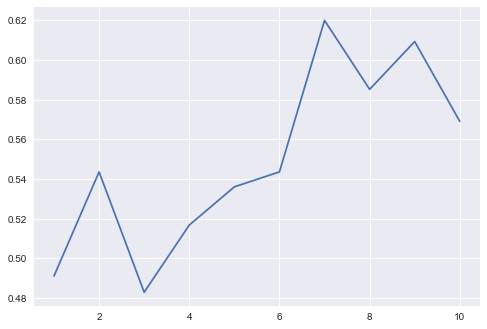

In [58]:
coherence_scores = []

for n in range(1, 11):
    mod = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                          id2word=dictionary,
                                          num_topics=n, 
                                          random_state=117, update_every=1,
                                          chunksize=1500, 
                                          passes=5, iterations=10,
                                          alpha='asymmetric', eta=1/100,
                                          per_word_topics=True)
    cmodel = gensim.models.coherencemodel.CoherenceModel(model=mod,
                                                 texts=processed_text,
                                                 dictionary=dictionary)
    coherence_scores.append((n, cmodel.get_coherence()))
    
topic_range = [coherence_scores[i][0] for i in range(len(coherence_scores))]
cscore = [coherence_scores[i][1] for i in range(len(coherence_scores))]

print(f'Coherence scores for the ngram range: {ngram_range} \n {coherence_scores}')
plt.plot(topic_range,cscore)